In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import mdtraj as mdt
from pathlib import Path
import matplotlib.pyplot as plt


import sys
sys.path.append("../../analysis")
from chem_shift import compute_chem_shift


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# traj = mdt.load("/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.xtc", top="/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.pdb")

# basepath = "/home/gzappavigna/traj/20240925_ff99sb-ildn-opc/"
# xtc = basepath + "7_prod_nojump.xtc"
# pdb = basepath + "7_prod_nojump.pdb"

# basepath = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/"
basepath = "/home/gzappavigna/traj/20241018_ff99sb-ildn_opc_multidir/"
xtc = basepath + "final_nojump.xtc"
pdb = basepath + "final_nojump.pdb"


# tot_frames = 900 * 1e3 / 0.5
# n_frames = 300 * 1e3 / 0.5
# traj = next(mdt.iterload(xtc, top=pdb, chunk=n_frames, skip=0))
# traj = next(mdt.iterload(xtc, top=pdb, chunk=n_frames, skip=tot_frames-n_frames))

traj = mdt.load(xtc, top=pdb, stride=3)
# traj = mdt.load(xtc, top=pdb, stride=2)

In [ ]:
df = compute_chem_shift(traj, period=100)

In [4]:
ca_rc_cs = df[["SHIFT", "RC_SHIFT"]].xs("CA", level=2).groupby(level=1).mean()

ca_rc_cs.index = ca_rc_cs.index - 1
ca_rc_cs.index.name = None

sim_ca_cs = ca_rc_cs["SHIFT"]
rc_cs = ca_rc_cs["RC_SHIFT"]

In [5]:
df["SIGMA"].xs("CA", level=2).mean()

0.9617521728097442

In [6]:
# ca_sigma2 = df["SIGMA"].xs("CA", level=2).apply(lambda x: x**2)
ca_sigma2 = df["SIGMA"].xs("CA", level=2)

grouper = ca_sigma2.groupby(level=1)
# sim_ca_sigma = np.sqrt(grouper.sum()) / grouper.count()
sim_ca_sigma = grouper.mean()

In [7]:
atom_name = "(?:CA)|(?:CO)|N|(?:HN)"
pattern = rf"^(\d{{1,3}})([A-Z]?)({atom_name})-(\d{{1,3}})([A-Z]?)({atom_name})-({atom_name})$"

exp = pd.read_csv("lists_Ntail/Ntail_HNCOCA.list", sep=" ", header=None)
# exp = pd.read_csv("lists_Ntail/Ntail_HNCA.list", sep=" ", header=None)
seq_cs = "".join(exp[0].str.extract(pattern)[1])


info = exp[0].str.extract(pattern)


In [8]:
top = traj.topology
exp_ca_cs = pd.Series(exp[1].to_numpy(), index=info[0].astype(int) - 525 + top.n_residues - 1)

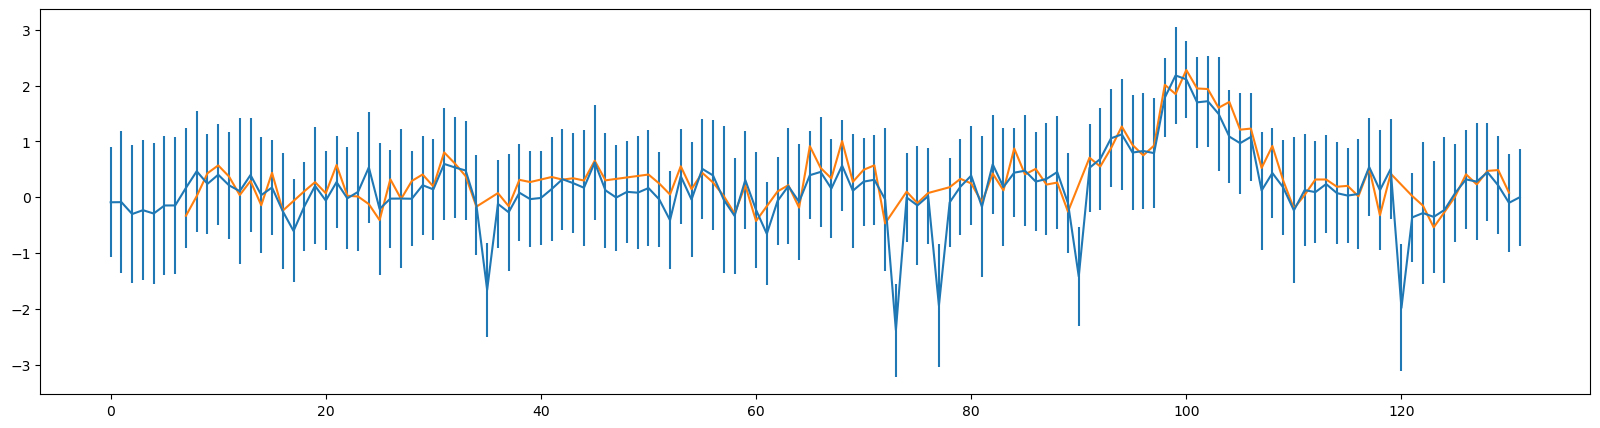

In [9]:
plt.figure(figsize=(20, 5))

# plt.plot(sim_ca_cs - rc_cs)
plt.errorbar(sim_ca_cs.index, sim_ca_cs - rc_cs, sim_ca_sigma)
plt.plot((exp_ca_cs - rc_cs).dropna())

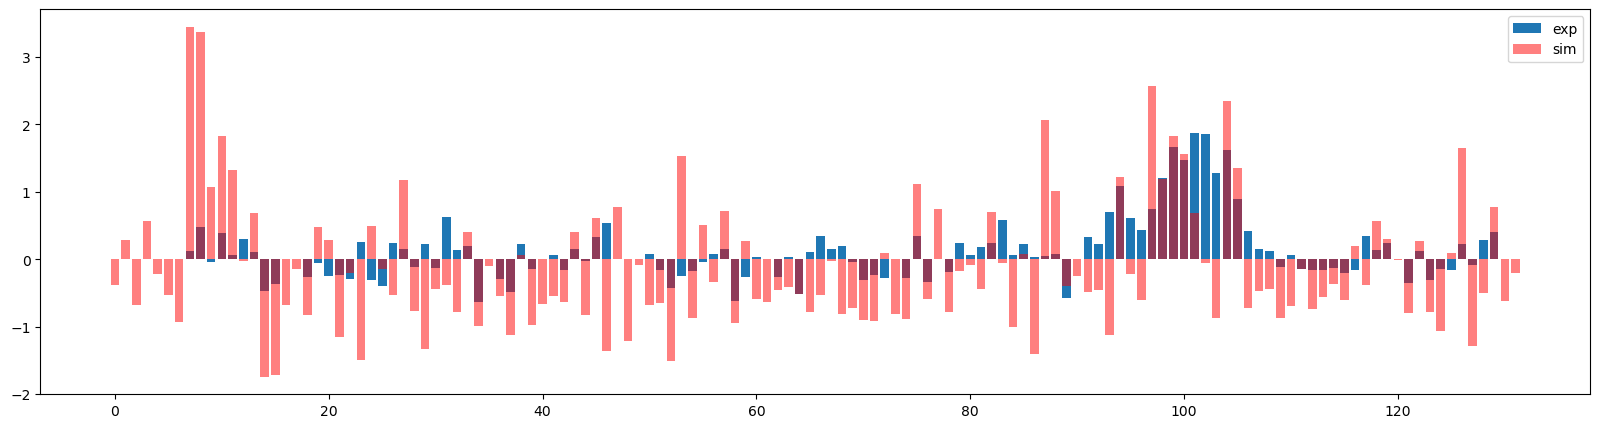

In [17]:
from chem_shift import compute_secondary_cs


plt.figure(figsize=(20, 5))


exp_idx2scs = compute_secondary_cs(residues, exp_idx2cs)

indx, scs = np.array(list(exp_idx2scs.keys())), np.array(list(exp_idx2scs.values()))
plt.bar(indx, scs, label="exp")

sim_idx2scs = compute_secondary_cs(residues, mu.to_dict())

indx, scs = np.array(list(sim_idx2scs.keys())), np.array(list(sim_idx2scs.values()))
# plt.bar(indx, scs, label="sim") # color='orange')
# plt.errorbar(indx, scs, sigma.to_list(), label="sim", color='orange')
plt.bar(indx, scs, label="sim", color='red', alpha=0.5)


plt.legend()


In [34]:
orig_inds = exp[0].str.extract(pattern)[0].astype(int).to_numpy()
orig_inds = orig_inds - orig_inds[0] + 7
orig_inds

array([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  36,  37,  38,  39,  41,  42,  43,  44,  45,  46,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130])

In [35]:
delta_sim = np.diff(inds_sim)
delta_sim


NameError: name 'inds_sim' is not defined

In [ ]:
from Bio import SeqIO
res = SeqIO.parse("/data/gzappavigna/traj/a99sb-ildn_opc/step5_production_nojump.pdb", "pdb-atom")
seq_sim = str(list(res)[0].seq)

In [37]:
from Bio import Align

aligner = Align.PairwiseAligner()

alignments = aligner.align(seq_sim, seq_cs)
alignment = alignments[0]
print(alignment)

NameError: name 'seq_sim' is not defined

In [19]:
inds = alignment.indices

inds_sim, inds_exp = inds[:, np.all(inds != -1, axis=0)]

NameError: name 'alignment' is not defined

In [33]:
np.diff(inds_sim)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
exp[1].iloc[inds_exp[:-1]].size

109

In [15]:
mu.loc[inds_sim[:-1]].size

109

In [21]:
exp

,0,1,2,3
0,401CA-402TN-HN,61.768,116.006,8.227
1,402CA-403EN-HN,62.120,122.950,8.437
2,403CA-404DN-HN,56.830,121.548,8.326
3,404CA-405KN-HN,54.571,121.138,8.209
4,405CA-406IN-HN,56.659,121.142,8.048
...,...,...,...,...
108,520CA-521RN-HN,54.411,120.790,8.183
109,521CA-522N-HN,56.330,119.179,8.440
110,522CA-523LN-HN,53.522,121.904,8.079
111,523CA-524LN-HN,55.327,122.212,8.089


In [ ]:
plt.figure(figsize=(20, 5))

# plt.plot(exp[1].loc[inds_exp[:-1]].to_numpy())
plt.plot(exp[1][:-1].to_numpy())
# plt.plot(mu.loc[inds_sim[:-1]].to_numpy())
plt.plot(mu.loc[orig_inds[:-1]].to_numpy())

In [51]:
inds_exp[0]

0

In [ ]:
from MDAnalysis.lib.util import convert_aa_code
from parse import parse

exp = pd.read_csv("secondary_cs_temp/ntail_25c_ca.scs", sep=" ", header=None, names=["residue", "diff", "cs", "rc_cs"])
"".join(exp.residue.apply(lambda x: convert_aa_code(list(parse("{:3d}{:3}", x))[1])).to_numpy())


In [ ]:

plt.figure(figsize=(20, 5))
# plt.errorbar(x=np.arange(mu.size), y=mu, yerr=sigma)
plt.bar(np.arange(mu.size), mu - exp.rc_cs)